# Classification of Pneumonia, Covid-19, and Normal Chest X-ray Using deep learning models

### imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from tensorflow.keras.models import load_model

### Allow GPU if have

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Defining path to data source

In [3]:
train_data_dir = r'C:\Users\Student\Documents\FA\DS\train'
val_data_dir = r'C:\Users\Student\Documents\FA\DS\val'
test_data_dir = r'C:\Users\Student\Documents\FA\DS\test'

### Hyperparameters or fixed parameters

In [4]:
batch_size = 32 # 16
input_shape = (256,256,3)
num_classes = 3

### Data Augmentation technique

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [6]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3659 images belonging to 3 classes.
Found 783 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


### Loading base model of VGG16 without the last layers

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape) # 50, 20, 30

### Add custom layer of classification

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

### Defining model

In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

### Avoid previous layers from re-training

In [10]:
for layer in base_model.layers:
    layer.trainable = False

### Print Summary

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### compile model 

In [12]:
model.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy']) # Adam

In [13]:
model_checkpoint = ModelCheckpoint("vgg16_model.h5", save_best_only=True,save_weights_only=False)
model_early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

### Load the save model

In [14]:
#loaded_model = load_model(r'vgg19_model.h5')

In [15]:
#print(loaded_model.history.history)

### Train the model

In [16]:
epochs = 10 # minimum 30. Possible 100 epochs
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[model_checkpoint, model_early_stopping])
# class weights Adam

Epoch 1/10
115/115 [==============================] - 391s 3s/step - loss: 1.0330 - accuracy: 0.4766 - val_loss: 0.9376 - val_accuracy: 0.7190
Epoch 2/10
115/115 [==============================] - 396s 3s/step - loss: 0.9011 - accuracy: 0.6802 - val_loss: 0.8415 - val_accuracy: 0.6207
Epoch 3/10
115/115 [==============================] - 380s 3s/step - loss: 0.8189 - accuracy: 0.7125 - val_loss: 0.7671 - val_accuracy: 0.6935
Epoch 4/10
115/115 [==============================] - 398s 3s/step - loss: 0.7546 - accuracy: 0.7270 - val_loss: 0.7378 - val_accuracy: 0.7241
Epoch 5/10
115/115 [==============================] - 383s 3s/step - loss: 0.7083 - accuracy: 0.7442 - val_loss: 0.6982 - val_accuracy: 0.7190
Epoch 6/10
115/115 [==============================] - 379s 3s/step - loss: 0.6745 - accuracy: 0.7669 - val_loss: 0.6528 - val_accuracy: 0.7714
Epoch 7/10
115/115 [==============================] - 379s 3s/step - loss: 0.6405 - accuracy: 0.7770 - val_loss: 0.6088 - val_accuracy: 0.8046

### Load weights

In [17]:
model.load_weights(r'vgg16_model.h5')

### Moael evaluation on test set

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}%")

25/25 [==============================] - 65s 3s/step - loss: 0.5428 - accuracy: 0.8232
Test Accuracy: 0.82%


### Confusion Matrix

In [19]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix")
print(cm)

25/25 [==============================] - 65s 3s/step
Confusion Matrix
[[214  27   4]
 [  3 264   4]
 [ 38  63 169]]


### Visualiza confusion Matrix

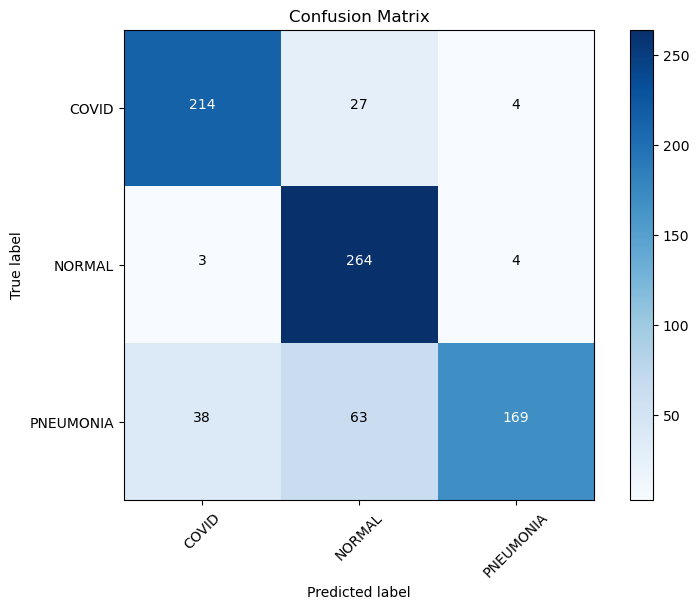

In [20]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = list(test_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Classification Report

In [21]:
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report) #

Classification Report:
              precision    recall  f1-score   support

       COVID       0.84      0.87      0.86       245
      NORMAL       0.75      0.97      0.84       271
   PNEUMONIA       0.95      0.63      0.76       270

    accuracy                           0.82       786
   macro avg       0.85      0.82      0.82       786
weighted avg       0.85      0.82      0.82       786



### visualize classification report

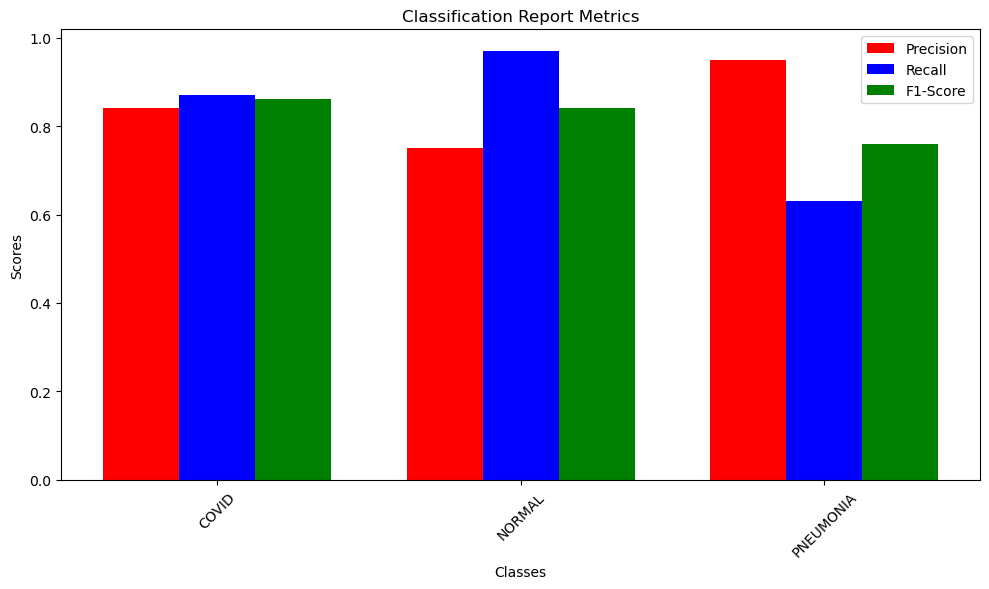

In [22]:
# Visualize the classification report
report_data = class_report.split('\n')
report_data = [data.split() for data in report_data if data]  # Split by spaces

classes = [data[0] for data in report_data[1:-3]]  # Extract classes
precision = [float(data[1]) for data in report_data[1:-3]]  # Extract precision values
recall = [float(data[2]) for data in report_data[1:-3]]  # Extract recall values
f1_score = [float(data[3]) for data in report_data[1:-3]]  # Extract F1-score values

plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(classes))

plt.bar(index, precision, bar_width, color='r', label='Precision')
plt.bar([i + bar_width for i in index], recall, bar_width, color='b', label='Recall')
plt.bar([i + 2 * bar_width for i in index], f1_score, bar_width, color='g', label='F1-Score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks([i + bar_width for i in index], classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Plots results

In [24]:
#history = loaded_model.history
#print(history.history)

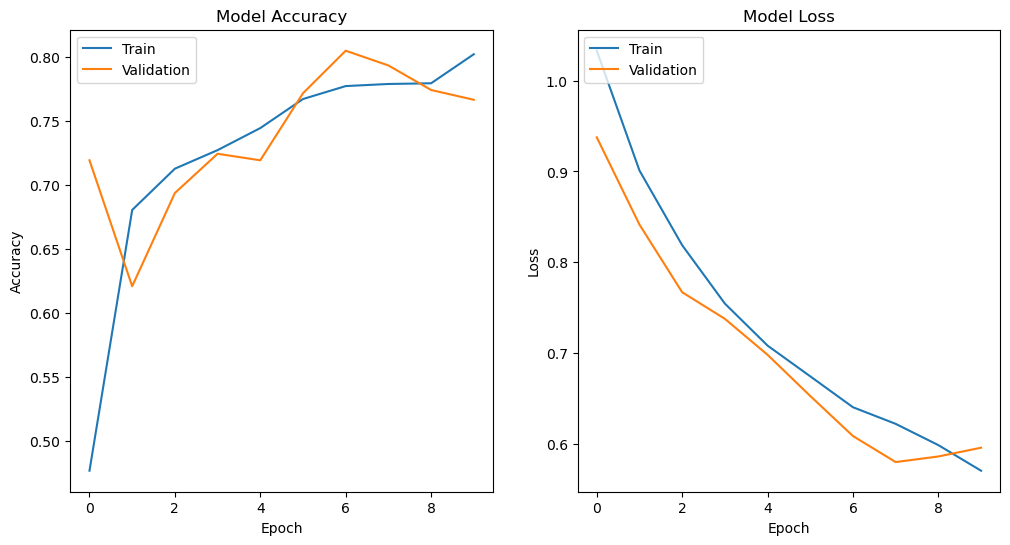

In [27]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()